In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from google.colab import drive 
import os
import itertools
from tqdm import tqdm
drive.mount('/content/drive')
os.chdir('drive/MyDrive/SummerDO')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Cleaning and Processing for Mean Differences

In [2]:
accepted = pd.read_csv("Final Code Repo/Data/accepted_2007_to_2018Q4.csv").sample(frac = 1, axis = 0, random_state = 0)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
accepted = accepted[accepted['grade'].isna() == False]

grades = sorted(accepted['grade'].unique())
accepted['term_y'] = [int(str(value)[:3])/12 for value in accepted['term']]

grades = grades[:5]

accepted['month'] = pd.PeriodIndex(accepted['issue_d'], freq='M')
accepted.set_index("month", inplace = True)
accepted = accepted.sort_values(by = 'month')

accepted['month'] = accepted.index

accepted['int_rate']/= 100

In [4]:
accepted['loan_status_ind'] = accepted["loan_status"].map({"Current" : -1, "Fully Paid" : 1, 
                                        "In Grace Period" : -1, "Charged Off" : 0, 
                                        "Default" : 0, "Late (16-30 days)" : 0, "Late (31-120 days)" : 0})

accepted = accepted[accepted['loan_status_ind'] != -1]


Actual_payoff = accepted['loan_amnt']*(1+accepted['int_rate']*accepted['term_y'])*(accepted['loan_status_ind'])
Actual_return = (100*(Actual_payoff - accepted['loan_amnt'])/accepted['loan_amnt'])/accepted['term_y']
accepted['ann_return'] = Actual_return

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [5]:
accepted['real_payoff'] = accepted['loan_amnt']*(1+accepted['int_rate']*accepted['term_y'])*(accepted['loan_status_ind'])
accepted['real_return'] = (100*(accepted['real_payoff'] - accepted['loan_amnt'])/accepted['loan_amnt'])/accepted['term_y']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
accepted['loan_status_ind_neg'] = accepted['loan_status_ind'].replace({0:1, 1:0})

accepted['real_payoff_with_recoup'] = accepted['loan_amnt']*(1+accepted['int_rate']*accepted['term_y'])*(accepted['loan_status_ind']) + accepted['loan_status_ind_neg']*(accepted['total_rec_prncp'] + accepted['total_rec_int'])

accepted['real_return_with_recoup'] = (100*(accepted['real_payoff_with_recoup'] - accepted['loan_amnt'])/accepted['loan_amnt'])/accepted['term_y']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
accepted = accepted[~accepted['real_return_with_recoup'].isna()]

In [8]:
accepted['month'] = pd.PeriodIndex(accepted['issue_d'], freq='M')
accepted.set_index("month", inplace = True)
accepted = accepted.sort_values(by = 'month')

In [9]:
accepted_agg = (
    accepted
    .copy()
    .filter(['grade', 'issue_d', 'real_return_with_recoup', 'term_y'])
    .groupby(['grade', 'month']).mean()
    .reset_index()
)

accepted_agg.set_index("month", inplace = True)
accepted_agg = accepted_agg.sort_values(by = 'month')

# Data Cleaning and Processing for KS Test

In [10]:
accepted = pd.read_csv("accepted_2007_to_2018Q4.csv").sample(frac = 1, axis = 0, random_state = 0).reset_index(drop = True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
accepted['loan_status'] = accepted['loan_status'].map({'Does not meet the credit policy. Status:Charged Off' : 'Charged Off',
                                                       'Does not meet the credit policy. Status:Fully Paid' : 'Fully Paid',
                                                       'Current' : 'Current', 'Fully Paid' : 'Fully Paid', 'In Grace Period' : 'In Grace Period',
                                                       'Charged Off' : 'Charged Off', 'Default' : 'Default', "Late (16-30 days)" : "Late (16-30 days)", 
                                                       "Late (31-120 days)" : "Late (31-120 days)"})
accepted['loan_status_ind'] = accepted["loan_status"].map({"Current" : -1, "Fully Paid" : 1, 
                                        "In Grace Period" : -1, "Charged Off" : 0, 
                                        "Default" : 0, "Late (16-30 days)" : 0, "Late (31-120 days)" : 0})
accepted = accepted.loc[accepted['loan_status_ind'] != -1]
accepted = accepted.loc[pd.notna(accepted['term'])]
accepted['term_y'] = [int(str(value)[:3])/12 for value in accepted['term']]
accepted['issue_d'] = pd.to_datetime(accepted['issue_d'])
accepted['month'] = pd.PeriodIndex(accepted['issue_d'], freq='M')
accepted.set_index("month", inplace = True)
accepted = accepted.sort_values(by = 'month')
accepted['issue_y'] = accepted.index.year
accepted['int_rate'] = accepted['int_rate'] / 100

In [12]:
accepted['real_payoff'] = accepted['loan_amnt']*(1+accepted['int_rate']*accepted['term_y'])*(accepted['loan_status_ind'])
accepted['real_return'] = (100*(accepted['real_payoff'] - accepted['loan_amnt'])/accepted['loan_amnt'])/accepted['term_y']

In [13]:
accepted['loan_status_ind_neg'] = accepted['loan_status_ind'].replace({0:1, 1:0})

accepted['real_payoff_with_recoup'] = accepted['loan_amnt']*(1+accepted['int_rate']*accepted['term_y'])*(accepted['loan_status_ind']) + accepted['loan_status_ind_neg']*(accepted['total_rec_prncp'] + accepted['total_rec_int'])

accepted['real_return_with_recoup'] = (100*(accepted['real_payoff_with_recoup'] - accepted['loan_amnt'])/accepted['loan_amnt'])/accepted['term_y']

In [14]:
accepted.index = accepted['issue_d']

In [15]:
accepted_ks = accepted.filter(['grade', 'real_return_with_recoup'])

accepted_ks.index = pd.DatetimeIndex(accepted_ks.index)
accepted_ks = accepted_ks.sort_values(by = 'issue_d')
accepted_ks = accepted_ks.reset_index()

# Mean Differences Test

In [16]:
Expected_return_by_grade = {}
Actual_return_by_grade = {}
 
for grade in grades:

  Loan_for_grade = accepted_agg[accepted_agg['grade'] == grade]
  Ann_return_grade = Loan_for_grade['real_return_with_recoup']

  # SR = Actual_return.mean()/Actual_return.std()
  print("------")
  print(grade)
  print(Ann_return_grade.mean())
  print("------")

  # Expected_return_by_grade[grade] = Expected_return
  Actual_return_by_grade[grade] = Ann_return_grade

------
A
5.885834505027408
------
------
B
7.013954206802012
------
------
C
7.471625583547297
------
------
D
7.792895286255233
------
------
E
8.664298763812997
------


In [17]:
df = Actual_return_by_grade['A'].describe()

for grade in grades[1:]:
  df = pd.concat([df, Actual_return_by_grade[grade].describe()], axis = 1)



In [18]:
to_test = list(itertools.combinations(grades, r = 2))

test_df = pd.DataFrame(index = to_test)
mean_diffs = []
t_stats = []
CIs = []
p_values = []

for groups in to_test:
    
  r1 = Actual_return_by_grade[groups[0]]
  r2 = Actual_return_by_grade[groups[1]]

  m1 = r1.mean()
  m2 = r2.mean()

  v1 = r1.std()**2
  v2 = r2.std()**2

  diff_r1_r2 = m1 - m2

  n1 = r1.shape[0]
  n2 = r2.shape[0]

  S_var = ((n1-1)*v1 + (n2-1)*v2)/(n1+n2-2)
  S_std = np.sqrt(S_var/n1 + S_var/n2)

  Z = diff_r1_r2/S_std
  DF = n1 + n2 - 2

  if diff_r1_r2 > 0:
    p_val = round(scipy.stats.t.sf(Z, df=DF),5)
  else:
    p_val = round(1 - scipy.stats.t.sf(Z, df=DF),5)

  mean_diffs.append(diff_r1_r2)
  t_stats.append(Z)

  CI = [round(diff_r1_r2 - 1.96*S_std, 3), round(diff_r1_r2 + 1.96*S_std, 3)]

  CIs.append((CI[0], CI[1]))

  p_values.append(p_val)

test_df["Mean (μ_1 - μ_2)"] = mean_diffs
test_df["CI (μ_1 - μ_2)"] = CIs
test_df["t_stat"] = t_stats
test_df["Pr(t)"] = p_values


In [19]:
test_df

,Mean (μ_1 - μ_2),CI (μ_1 - μ_2),t_stat,Pr(t)
"(A, B)",-1.128120,"(-1.529, -0.727)",-5.509848,0.00000
"(A, C)",-1.585791,"(-2.107, -1.065)",-5.967868,0.00000
"(A, D)",-1.907061,"(-2.54, -1.274)",-5.908999,0.00000
"(A, E)",-2.778464,"(-3.523, -2.034)",-7.315981,0.00000
"(B, C)",-0.457671,"(-1.054, 0.139)",-1.503896,0.06688
"(B, D)",-0.778941,"(-1.476, -0.082)",-2.191582,0.01463
"(B, E)",-1.650345,"(-2.45, -0.851)",-4.045750,0.00003
"(C, D)",-0.321270,"(-1.093, 0.451)",-0.815438,0.20777
"(C, E)",-1.192673,"(-2.059, -0.327)",-2.698823,0.00370
"(D, E)",-0.871403,"(-1.811, 0.069)",-1.816986,0.03516


## Plotting Distribution of Returns

In [20]:
import seaborn as sns

accept_grades = ["A", "B", "C","D"]
accepted_box = accepted_agg[accepted_agg['grade'].isin(accept_grades)]
accepted_box=accepted_box.drop('term_y', axis= 1)

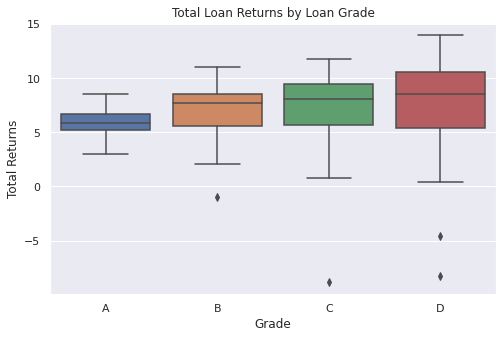

In [22]:

sns.set(rc={'figure.figsize':(8,5)})
ax = sns.boxplot(x="grade", y="real_return_with_recoup", order =accept_grades, data=accepted_box)
ax.set(xlabel='Grade', ylabel='Total Returns')
plt.title('Total Loan Returns by Loan Grade')
plt.show()

# Kolmogorov Smirnov Test

In [24]:
from scipy.stats import ks_2samp

p_vals = []

grades = sorted(accepted['grade'].unique())[0:5]
for i in range(len(grades)):
  for j in range(len(grades)):
      if (j > i):
        print(f'{grades[i]} vs {grades[j]}')  
        data1 = accepted_ks.loc[accepted_ks['grade'] == grades[i]]['real_return_with_recoup']
        data2 = accepted_ks.loc[accepted_ks['grade'] == grades[j]]['real_return_with_recoup']

        n= len(data1)
        m = len(data2)
        c_alpha = 1.358

        D_alpha = c_alpha* np.sqrt((n+m)/(n*m))

        ks_result = ks_2samp(data1, data2)
        print(f'test statistic: {ks_result[0]}')
        print(f'p-value: {ks_result[1]}')
        p_vals.append(ks_result[1])
  
        print('-----')


A vs B
test statistic: 0.7661558592332611
p-value: 0.0
-----
A vs C
test statistic: 0.75736994478131
p-value: 0.0
-----
A vs D
test statistic: 0.6767878410893644
p-value: 0.0
-----
A vs E
test statistic: 0.5999793303017775
p-value: 0.0
-----
B vs C
test statistic: 0.6360300602910335
p-value: 0.0
-----
B vs D
test statistic: 0.6746131628308428
p-value: 0.0
-----
B vs E
test statistic: 0.5985531211244316
p-value: 0.0
-----
C vs D
test statistic: 0.5606493128621299
p-value: 0.0
-----
C vs E
test statistic: 0.585386523356759
p-value: 0.0
-----
D vs E
test statistic: 0.3585221937594397
p-value: 0.0
-----


## Bonferoni p-value Correction

In [31]:
from statsmodels.sandbox.stats.multicomp import multipletests
rejected, p_adjusted, _, alpha_corrected = multipletests(p_vals,alpha= 0.05, method='bonferroni',is_sorted=False, returnsorted=False)
p_adjusted

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])